In [1]:
%env JOBLIB_TEMP_FOLDER=/home/tangsp/scratch/tmp
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

env: JOBLIB_TEMP_FOLDER=/home/tangsp/scratch/tmp


In [2]:
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
})

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import itertools

In [4]:
PROB_DIAB = 0.2
NSTEPS = 20     # max episode length

In [5]:
# Ground truth MDP model
MDP_parameters = joblib.load('../data/MDP_parameters.joblib')
P_ = MDP_parameters['transition_matrix_absorbing'] # (A, S, S_next)
R_ = MDP_parameters['reward_matrix_absorbing_SA'] # (S, A)
nS, nA = R_.shape
γ = gamma = 0.99

# unif rand isd, mixture of diabetic state
isd = joblib.load('../data/prior_initial_state_absorbing.joblib')

In [6]:
# Optimal value function and optimal return
V_star = joblib.load('../data/V_π_star_PE.joblib')
J_star = V_star @ isd

In [7]:
# Make features for all states
X_ALL_states = []
for arrays in itertools.product(
    [[1,0], [0,1]], # Diabetic
    [[1,0,0], [0,1,0], [0,0,1]], # Heart Rate
    [[1,0,0], [0,1,0], [0,0,1]], # SysBP
    [[1,0], [0,1]], # Percent O2
    [[1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1]], # Glucose
    [[1,0], [0,1]], # Treat: AbX
    [[1,0], [0,1]], # Treat: Vaso
    [[1,0], [0,1]], # Treat: Vent
):
    X_ALL_states.append(np.concatenate(arrays))

X_ALL_states = np.array(X_ALL_states)
X_ALL_states.shape

(1440, 21)

In [8]:
import tensorflow as tf
from tensorflow import keras
from tf_utils import select_output_d, select_output
from OPE_utils_keras import *

In [9]:
print('Load FQI models')
Ns = [50, 100, 200, 500, 1000, 2000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]
runs = list(range(10))
nl = 1
nh = 1000
lr = 1e-3
k_list = list(range(50))

Load FQI models


## Oracle Early Stopping

In [10]:
cases = ['eps_0_1', 'eps_0_5', 'eps_1', 'suboptimal', 'suboptimal99']
case_names = {
    'eps_0_1': 'ε = 0.1', 
    'eps_0_5': 'ε = 0.5', 
    'eps_1': 'ε = 1', 
    'suboptimal99': 'ε = 0.99*8/7',
    'suboptimal': 'ε = 8/7',
}
case_names = {
    'eps_0_1': '$\epsilon = 0.1$', 
    'eps_0_5': '$\epsilon = 0.5$', 
    'eps_1': '$\epsilon = 1$', 
    'suboptimal99': '$\epsilon = 0.99*8/7$',
    'suboptimal': '$\epsilon = 8/7$',
}

In [11]:
orig_true_value_dict = {
    case: joblib.load(f'./results/{case}/eval_NFQ.joblib')
    for case in cases
}

In [12]:
factor_true_value_dict = {
    case: joblib.load(f'./results/{case}/eval_NFQ_factored_v2.joblib')
    for case in cases
}

In [13]:
origNFQ_value_list = {
    case: [[[orig_true_value_dict[case].get((N, run, k), np.nan) for k in k_list] for run in runs] for N in Ns]
    for case in cases
}
factorNFQ_value_list = {
    case: [[[factor_true_value_dict[case].get((N, run, k), np.nan) for k in k_list] for run in runs] for N in Ns]
    for case in cases
}

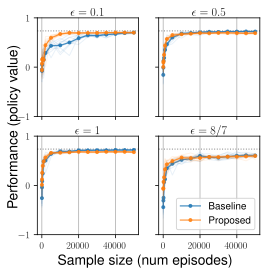

In [27]:
fig, axes = plt.subplots(2,2, figsize=(4,4), sharex=True, sharey=True)

for i, case in enumerate(cases[:4]):
    plt.sca(axes.ravel()[i])
    plt.plot(Ns, np.array([[np.max(oo) for oo in o] for o in origNFQ_value_list[case]]).mean(axis=1), 
             marker='.', c='tab:blue', lw=1.25, alpha=0.8, label='Baseline')
    plt.plot(Ns, np.array([[np.max(oo) for oo in o] for o in origNFQ_value_list[case]]), c='tab:blue', lw=1, alpha=0.1)

    plt.plot(Ns, np.array([[np.max(oo) for oo in o] for o in factorNFQ_value_list[case]]).mean(axis=1), 
             marker='.', c='tab:orange', lw=1.25, alpha=0.8, label='Proposed')
    plt.plot(Ns, np.array([[np.max(oo) for oo in o] for o in factorNFQ_value_list[case]]), c='tab:orange', lw=1, alpha=0.1)

    plt.axhline(J_star, c='gray', ls=':', lw=1, zorder=0)
    plt.grid(axis='x')
    plt.title(case_names[case], y=0.96)
    
    plt.ylim(-1,1)
    plt.yticks(np.arange(-1, 1.1, 1))

fig.supxlabel('Sample size (num episodes)', fontsize=14)
fig.supylabel('Performance (policy value)', fontsize=14)
plt.legend()
plt.savefig('./fig/sepsisSim-FQI-all-large.pdf', bbox_inches='tight')
plt.show()

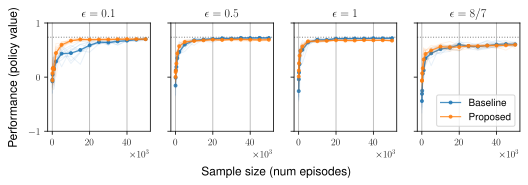

In [15]:
fig, axes = plt.subplots(1,4, figsize=(8.5,2), sharex=True, sharey=True)

for i, case in enumerate(cases):
    plt.sca(axes.ravel()[i])
    plt.plot(Ns, np.array([[np.max(oo) for oo in o] for o in origNFQ_value_list[case]]).mean(axis=1), 
             marker='.', c='tab:blue', lw=1.25, alpha=0.8, label='Baseline')
    plt.plot(Ns, np.array([[np.max(oo) for oo in o] for o in origNFQ_value_list[case]]), c='tab:blue', lw=1, alpha=0.1)

    plt.plot(Ns, np.array([[np.max(oo) for oo in o] for o in factorNFQ_value_list[case]]).mean(axis=1), 
             marker='.', c='tab:orange', lw=1.25, alpha=0.8, label='Proposed')
    plt.plot(Ns, np.array([[np.max(oo) for oo in o] for o in factorNFQ_value_list[case]]), c='tab:orange', lw=1, alpha=0.1)

    plt.axhline(J_star, c='gray', ls=':', lw=1, zorder=0)
    plt.grid(axis='x')
    plt.title(case_names[case])
    
    plt.ylim(-1,1)
    plt.yticks(np.arange(-1, 1.1, 1))
    plt.ticklabel_format(style='sci', scilimits=(3,3), useMathText=True, axis='x')

fig.supxlabel('Sample size (num episodes)', y=-0.2)
fig.supylabel('Performance (policy value)', x=0.06)
plt.legend()
plt.savefig('./fig/sepsisSim-FQI-all-large.pdf', bbox_inches='tight')
plt.show()

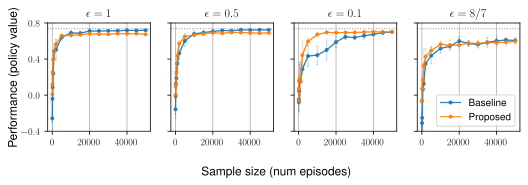

In [16]:
fig, axes = plt.subplots(1,4, figsize=(8.5,2), sharex=True, sharey=True)

plot_cases = [cases[2],cases[1],cases[0],cases[3]]

for i, case in enumerate(plot_cases): # reordered
    plt.sca(axes.ravel()[i])
    plt.plot(Ns, np.array([[np.max(oo) for oo in o] for o in origNFQ_value_list[case]]).mean(axis=1), 
             marker='.', c='tab:blue', lw=1.25, alpha=0.9, label='Baseline')
    plt.errorbar(
        Ns, np.array([[np.max(oo) for oo in o] for o in origNFQ_value_list[case]]).mean(axis=1), 
        yerr=np.array([[np.max(oo) for oo in o] for o in origNFQ_value_list[case]]).std(axis=1), 
        c='tab:blue', lw=1, alpha=0.3, capsize=1)

    plt.plot(Ns, np.array([[np.max(oo) for oo in o] for o in factorNFQ_value_list[case]]).mean(axis=1), 
             marker='.', c='tab:orange', lw=1.25, alpha=0.9, label='Proposed')
    plt.errorbar(
        Ns, np.array([[np.max(oo) for oo in o] for o in factorNFQ_value_list[case]]).mean(axis=1), 
        yerr=np.array([[np.max(oo) for oo in o] for o in factorNFQ_value_list[case]]).std(axis=1), 
        c='tab:orange', lw=1, alpha=0.3, capsize=1)

    plt.axhline(J_star, c='gray', ls=':', lw=1, zorder=0)
    plt.grid(axis='x')
    plt.title(case_names[case])
    
#     plt.xscale('log')
    plt.ylim(-0.4,0.8)
    plt.yticks(np.arange(-0.4, 0.9, 0.4))
#     plt.ticklabel_format(style='sci', scilimits=(3,3), useMathText=True, axis='x')

fig.supxlabel('Sample size (num episodes)', y=-0.2)
fig.supylabel('Performance (policy value)', x=0.06)
plt.legend()
plt.savefig('./fig/sepsisSim-FQI-all-large.pdf', bbox_inches='tight')
plt.show()

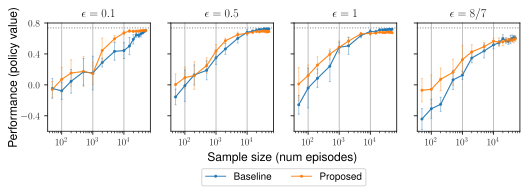

In [30]:
fig, axes = plt.subplots(1,4, figsize=(8.5,2), sharex=True, sharey=True)

plot_cases = [cases[0],cases[1],cases[2],cases[3]]

for i, case in enumerate(plot_cases): # reordered
    plt.sca(axes.ravel()[i])
    plt.plot(Ns, np.array([[np.max(oo) for oo in o] for o in origNFQ_value_list[case]]).mean(axis=1), 
             marker='.', c='tab:blue', ms=4, lw=1, alpha=0.9, label='Baseline')
    plt.errorbar(
        Ns, np.array([[np.max(oo) for oo in o] for o in origNFQ_value_list[case]]).mean(axis=1), 
        yerr=np.array([[np.max(oo) for oo in o] for o in origNFQ_value_list[case]]).std(axis=1), 
        c='tab:blue', lw=1, alpha=0.4, capsize=1)

    plt.plot(Ns, np.array([[np.max(oo) for oo in o] for o in factorNFQ_value_list[case]]).mean(axis=1), 
             marker='.', c='tab:orange', ms=4, lw=1, alpha=0.9, label='Proposed')
    plt.errorbar(
        Ns, np.array([[np.max(oo) for oo in o] for o in factorNFQ_value_list[case]]).mean(axis=1), 
        yerr=np.array([[np.max(oo) for oo in o] for o in factorNFQ_value_list[case]]).std(axis=1), 
        c='tab:orange', lw=1, alpha=0.4, capsize=1)

    plt.axhline(J_star, c='gray', ls=':', lw=1, zorder=0)
    plt.grid(axis='x')
    plt.title(case_names[case])
    
    plt.xscale('log')
    plt.ylim(-0.6,0.8)
    plt.yticks(np.arange(-0.4, 0.9, 0.4))
#     plt.ticklabel_format(style='sci', scilimits=(3,3), useMathText=True, axis='x')

fig.supxlabel('Sample size (num episodes)', x=0.51, y=-0.1)
fig.supylabel('Performance (policy value)', x=0.06)
plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(-1.3,-0.3))
plt.savefig('./fig/sepsisSim-FQI-all-large-logscale.pdf', bbox_inches='tight')
plt.show()

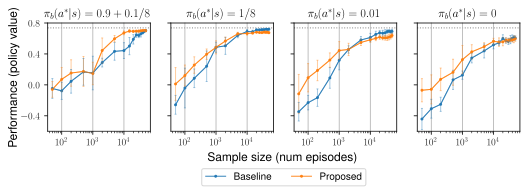

In [14]:
fig, axes = plt.subplots(1,4, figsize=(8.5,2), sharex=True, sharey=True)

plot_cases = [cases[0],cases[2],cases[4],cases[3]]
new_case_names = {
    'eps_0_1': '$\pi_b(a^*|s) = 0.9 + 0.1/8$', 
    'eps_1': '$\pi_b(a^*|s) = 1/8$', 
    'suboptimal99': '$\pi_b(a^*|s) = 0.01$',
    'suboptimal': '$\pi_b(a^*|s) = 0$',
}

for i, case in enumerate(plot_cases): # reordered
    plt.sca(axes.ravel()[i])
    plt.plot(Ns, np.array([[np.nanmax(oo) for oo in o] for o in origNFQ_value_list[case]]).mean(axis=1), 
             marker='.', c='tab:blue', ms=4, lw=1, alpha=0.9, label='Baseline')
    plt.errorbar(
        Ns, np.array([[np.nanmax(oo) for oo in o] for o in origNFQ_value_list[case]]).mean(axis=1), 
        yerr=np.array([[np.nanmax(oo) for oo in o] for o in origNFQ_value_list[case]]).std(axis=1), 
        c='tab:blue', lw=1, alpha=0.4, capsize=1)

    plt.plot(Ns, np.array([[np.nanmax(oo) for oo in o] for o in factorNFQ_value_list[case]]).mean(axis=1), 
             marker='.', c='tab:orange', ms=4, lw=1, alpha=0.9, label='Proposed')
    plt.errorbar(
        Ns, np.array([[np.nanmax(oo) for oo in o] for o in factorNFQ_value_list[case]]).mean(axis=1), 
        yerr=np.array([[np.nanmax(oo) for oo in o] for o in factorNFQ_value_list[case]]).std(axis=1), 
        c='tab:orange', lw=1, alpha=0.4, capsize=1)

    plt.axhline(J_star, c='gray', ls=':', lw=1, zorder=0)
    plt.grid(axis='x')
    plt.title(new_case_names[case])
    
    plt.xscale('log')
    plt.ylim(-0.6,0.8)
    plt.yticks(np.arange(-0.4, 0.9, 0.4))
#     plt.ticklabel_format(style='sci', scilimits=(3,3), useMathText=True, axis='x')

fig.supxlabel('Sample size (num episodes)', x=0.51, y=-0.1)
fig.supylabel('Performance (policy value)', x=0.06)
plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(-1.3,-0.3))
plt.savefig('./fig/sepsisSim-FQI-all-large-logscale-new.pdf', bbox_inches='tight')
plt.show()

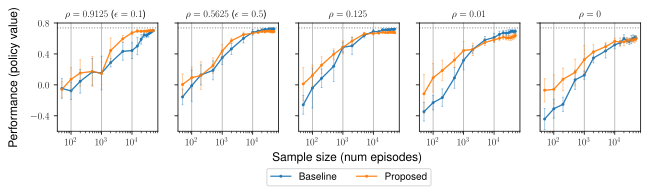

In [37]:
fig, axes = plt.subplots(1,5, figsize=(10.5,2), sharex=True, sharey=True)

plot_cases = [cases[0],cases[1],cases[2],cases[4],cases[3]]
new_case_names = {
    'eps_0_1': r'$\rho = 0.9125$ ($\epsilon = 0.1$)', 
    'eps_0_5': r'$\rho = 0.5625$ ($\epsilon = 0.5$)', 
    'eps_1': r'$\rho = 0.125$', 
    'suboptimal99': r'$\rho = 0.01$',
    'suboptimal': r'$\rho = 0$',
}

for i, case in enumerate(plot_cases): # reordered
    plt.sca(axes.ravel()[i])
    plt.plot(Ns, np.array([[np.nanmax(oo) for oo in o] for o in origNFQ_value_list[case]]).mean(axis=1), 
             marker='.', c='tab:blue', ms=4, lw=1.25, alpha=0.9, label='Baseline')
    plt.errorbar(
        Ns, np.array([[np.nanmax(oo) for oo in o] for o in origNFQ_value_list[case]]).mean(axis=1), 
        yerr=np.array([[np.nanmax(oo) for oo in o] for o in origNFQ_value_list[case]]).std(axis=1), 
        c='tab:blue', lw=1, alpha=0.4, capsize=1)

    plt.plot(Ns, np.array([[np.nanmax(oo) for oo in o] for o in factorNFQ_value_list[case]]).mean(axis=1), 
             marker='.', c='tab:orange', ms=4, lw=1.25, alpha=0.9, label='Proposed')
    plt.errorbar(
        Ns, np.array([[np.nanmax(oo) for oo in o] for o in factorNFQ_value_list[case]]).mean(axis=1), 
        yerr=np.array([[np.nanmax(oo) for oo in o] for o in factorNFQ_value_list[case]]).std(axis=1), 
        c='tab:orange', lw=1, alpha=0.4, capsize=1)

    plt.axhline(J_star, c='gray', ls=':', lw=1, zorder=0)
    plt.grid(axis='x')
    plt.title(new_case_names[case], fontsize=10)
    
    plt.xscale('log')
    plt.ylim(-0.6,0.8)
    plt.yticks(np.arange(-0.4, 0.9, 0.4))
#     plt.ticklabel_format(style='sci', scilimits=(3,3), useMathText=True, axis='x')

fig.supxlabel('Sample size (num episodes)', x=0.51, y=-0.1)
fig.supylabel('Performance (policy value)', x=0.06)
plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(-1.9,-0.3))
plt.savefig('./fig/sepsisSim-FQI-all-large-logscale-new.pdf', bbox_inches='tight')
plt.show()

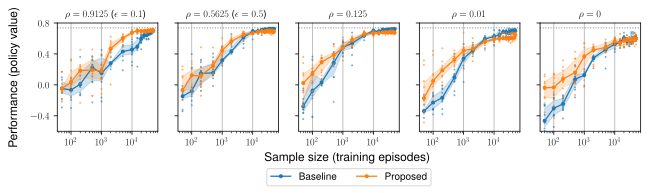

In [27]:
fig, axes = plt.subplots(1,5, figsize=(10.5,2), sharex=True, sharey=True)

plot_cases = [cases[0],cases[1],cases[2],cases[4],cases[3]]
new_case_names = {
    'eps_0_1': r'$\rho = 0.9125$ ($\epsilon = 0.1$)', 
    'eps_0_5': r'$\rho = 0.5625$ ($\epsilon = 0.5$)', 
    'eps_1': r'$\rho = 0.125$', 
    'suboptimal99': r'$\rho = 0.01$',
    'suboptimal': r'$\rho = 0$',
}

for i, case in enumerate(plot_cases): # reordered
    plt.sca(axes.ravel()[i])
    plt.plot(Ns, np.median(np.array([[np.nanmax(oo) for oo in o] for o in origNFQ_value_list[case]]), axis=1), 
             marker='.', c='tab:blue', ms=6, lw=1.25, alpha=1, label='Baseline')
    plt.plot(Ns, np.array([[np.nanmax(oo) for oo in o] for o in origNFQ_value_list[case]]), 
             ls='none', marker='.', c='tab:blue', ms=4, mew=0, lw=1.25, alpha=0.6)
    plt.fill_between(Ns, 
                     np.percentile(np.array([[np.nanmax(oo) for oo in o] for o in origNFQ_value_list[case]]), 25, axis=1),
                     np.percentile(np.array([[np.nanmax(oo) for oo in o] for o in origNFQ_value_list[case]]), 75, axis=1),
                     color='tab:blue', alpha=0.2)
#     plt.errorbar(
#         Ns, np.array([[np.nanmax(oo) for oo in o] for o in origNFQ_value_list[case]]).mean(axis=1), 
#         yerr=np.array([[np.nanmax(oo) for oo in o] for o in origNFQ_value_list[case]]).std(axis=1), 
#         c='tab:blue', lw=1, alpha=0.4, capsize=1)

    plt.plot(Ns, np.median(np.array([[np.nanmax(oo) for oo in o] for o in factorNFQ_value_list[case]]), axis=1), 
             marker='.', c='tab:orange', ms=6, lw=1.25, alpha=1, label='Proposed')
    plt.plot(Ns, np.array([[np.nanmax(oo) for oo in o] for o in factorNFQ_value_list[case]]), 
             ls='none', marker='.', c='tab:orange', ms=4, mew=0, lw=1.25, alpha=0.6)
    plt.fill_between(Ns, 
                     np.percentile(np.array([[np.nanmax(oo) for oo in o] for o in factorNFQ_value_list[case]]), 25, axis=1),
                     np.percentile(np.array([[np.nanmax(oo) for oo in o] for o in factorNFQ_value_list[case]]), 75, axis=1),
                     color='tab:orange', alpha=0.2)
#     plt.errorbar(
#         Ns, np.array([[np.nanmax(oo) for oo in o] for o in factorNFQ_value_list[case]]).mean(axis=1), 
#         yerr=np.array([[np.nanmax(oo) for oo in o] for o in factorNFQ_value_list[case]]).std(axis=1), 
#         c='tab:orange', lw=1, alpha=0.4, capsize=1)

    plt.axhline(J_star, c='gray', ls=':', lw=1, zorder=0)
    plt.grid(axis='x')
    plt.title(new_case_names[case], fontsize=10)
    
    plt.xscale('log')
    plt.ylim(-0.6,0.8)
    plt.yticks(np.arange(-0.4, 0.9, 0.4))
#     plt.ticklabel_format(style='sci', scilimits=(3,3), useMathText=True, axis='x')

fig.supxlabel('Sample size (training episodes)', x=0.51, y=-0.1)
fig.supylabel('Performance (policy value)', x=0.06)
plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(-1.9,-0.3))
plt.savefig('./fig/sepsisSim-FQI-all-large-logscale-median.pdf', bbox_inches='tight')
plt.show()